# Classifying CIFAR10 images using ResNets, Regularization and Data Augmentation in PyTorch

이 파트에서는 CIFAR10 데이터 세트에서 이미지를 분류할 때 90% 이상의 정확도를 달성하기 위해 다음 기술을 사용하여 5분 이내에 최첨단 모델을 훈련합니다.

* 데이터 정규화(data normalization)
* 데이터 증강(Augmentation)
* 잔여(Residual) 연결
* 배치 정규화(Batch normalization)
* 학습률 스케줄링
* Weight Decay
* Gradient clipping
* Adam 옵티마이저

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

## Preparing the CIFAR10 Dataset

이 노트북은 PyTorch에서 CNN을 사용한 이미지 분류 튜토리얼(여기에서 약 75%의 정확도로 CIFAR10 데이터 세트의 이미지를 분류하기 위해 심층 합성곱 신경망을 훈련)의 확장판으로, 다음은 데이터 세트의 일부 이미지입니다.

![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)

이전 튜토리얼에서 했던 것처럼 데이터 세트를 다운로드하고, PyTorch 데이터 세트를 생성하여 데이터를 로드하는 것으로 시작하겠습니다.

In [ ]:
from torchvision.datasets.utils import download_url

# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [2]:
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torchvision의 ImageFolder 클래스를 사용하여 훈련 및 검증 데이터 세트를 생성할 수 있습니다. ToTensor 변환 외에도 이미지에 다른 변환도 적용합니다. 훈련 및 검증을 위해 PyTorch 데이터 세트를 생성하는 동안 몇 가지 중요한 변경 사항이 있습니다.

1. 검증을 위해 테스트 세트 사용: 검증을 위해 훈련 세트에서 데이터의 일부(예: 10%)를 따로 설정하는 대신 테스트 세트를 검증 세트로 사용합니다. 이것은 훈련할 데이터를 조금 더 제공할 뿐입니다. 일반적으로 고정된 유효성 검사 세트를 사용하여 최고의 모델 아키텍처 및 하이퍼파라미터를 선택한 후에는 전체 데이터 세트에서 동일한 모델을 재교육하여 최종 성능을 약간 향상시키는 것이 좋습니다.

2. 채널별 데이터 정규화(data normalization): 각 채널에서 평균을 빼고 표준 편차로 나누어 이미지 텐서를 정규화합니다. 결과적으로 각 채널의 데이터 평균은 0이고 표준편차는 1입니다. 데이터를 정규화하면 단순히 다른 채널보다 더 높거나 더 넓은 범위의 값을 가짐으로써 한 채널의 값이 훈련 중에 손실 및 그라디언트에 불균형하게 영향을 미치는 것을 방지할 수 있습니다.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">

3. 무작위 데이터 증강(data argumentation): 교육 데이터 세트에서 이미지를 로드하는 동안 무작위로 선택한 변환을 적용합니다. 구체적으로 각 이미지를 4픽셀씩 패딩한 다음, 32 x 32픽셀 크기의 임의 크롭을 취한 다음, 50% 확률로 이미지를 가로로 뒤집습니다. 변환은 특정 이미지가 로드될 때마다 무작위로 동적으로 적용되므로 모델은 훈련의 각 에포크에서 약간 다른 이미지를 보게 되므로 더 잘 일반화할 수 있습니다.

![데이터 확대](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [3]:
# Data transforms (normalization & data augmentation)

'''
Data Normalize example

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True)
data = cifar_trainset.data / 255 # data is numpy array
mean = data.mean(axis = (0,1,2)) 
std = data.std(axis = (0,1,2))
'''
stats = ((0.491, 0.482, 0.446), (0.202, 0.199, 0.201))  # ((means),(stds))

train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(*stats, inplace=True)])

valid_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(*stats)])

In [5]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_transform)
valid_ds = ImageFolder(data_dir+'/test', valid_transform)

In [6]:
len(train_ds), len(valid_ds)

(50000, 10000)

다음으로 이미지를 배치로 가져오기 위한 데이터 로더를 생성할 수 있습니다. GPU RAM의 더 많은 부분을 활용하기 위해 비교적 큰 배치 크기인 500을 사용할 것입니다. "메모리 부족" 오류가 발생하면 배치 크기를 줄이고 커널을 다시 시작할 수 있습니다.

In [7]:
batch_size = 400

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

훈련 데이터 로더의 일부 샘플 이미지를 살펴보겠습니다. 이미지를 표시하려면 픽셀 값을 비정규화(denormalize) 하여 (0,1) 범위로 되돌려야 합니다.

In [8]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

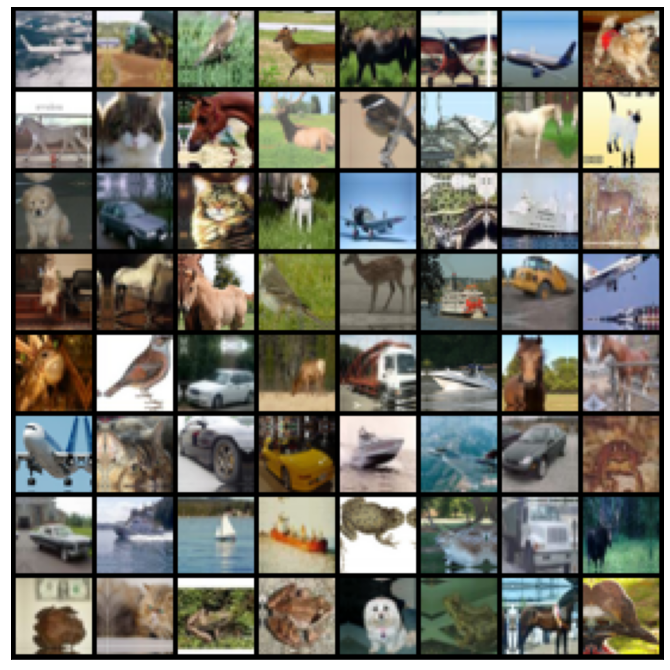

In [9]:
show_batch(train_dl)

정규화로 인해 색상이 적절하지 않은 것처럼 보입니다. 정규화는 추론 중에도 적용됩니다. 자세히 보면 일부 이미지에서 자르기 및 반사 패딩을 볼 수 있습니다. 수평 플립은 육안 검사에서 감지하기가 약간 어렵습니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Using a GPU

GPU를 원활하게 사용하기 위해 사용 가능한 경우 몇 가지 도우미 함수(get_default_device 및 to_device)와 도우미 클래스 DeviceDataLoader를 정의하여 필요에 따라 모델 및 데이터를 GPU로 이동합니다. 이에 대한 자세한 내용은 이전 자습서에 설명되어 있습니다.

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

이 노트북을 실행하는 위치에 따라 기본 장치는 CPU(torch.device('cpu')) 또는 GPU(torch.device('cuda'))일 수 있습니다.

In [11]:
device = get_default_device()
device

device(type='cuda')

이제 데이터 배치를 GPU(사용 가능한 경우)로 자동 전송하기 위해 'DeviceDataLoader'를 사용하여 훈련 및 검증 데이터 로더를 래핑할 수 있습니다.

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

이번 CNN 모델의 주요 변경 사항 중 하나는 resudial 블록을 추가한 것입니다. 이 블록은 하나 이상의 컨볼루션 레이어를 통해 입력을 전달하여 얻은 출력 특징 맵에 원래 입력을 다시 추가합니다.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

다음은 매우 간단한 Residual 블록입니다.

In [13]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(3, 3, 3, 1, 1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [14]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


이 작은 변화는 모델의 성능을 크게 향상시킵니다. 또한 각 컨볼루션 레이어 뒤에 배치 정규화 레이어를 추가하여 이전 레이어의 출력을 정규화합니다.

자세한 내용은 다음 블로그 게시물을 참조하십시오.

* Residual 블록이 작동하는 이유와 방법: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* 배치 정규화 및 드롭아웃 설명: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

[이 블로그 시리즈](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/)에 설명된 대로 여기서는 ResNet9 아키텍처를 사용합니다.

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [19]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

----------------------------------------------------------------------------------------------------------------------------------------

## Train model

모델을 훈련하기 전에 fit 함수에 작지만 중요한 개선 사항을 많이 적용할 것입니다.

* 학습률 스케줄링(Learning rate scheduling): 고정된 학습률을 사용하는 대신 학습률 스케줄러를 사용하여 모든 훈련 배치 후에 학습률을 변경합니다. 교육 중에 학습률을 변경하는 많은 전략이 있으며, 우리가 사용할 전략은 "1주기 학습률 정책(One Cycle Learning Rate Policy)"이라고 합니다. 이 정책은 낮은 학습률에서 시작하여 점진적으로 배치 단위로 증가시킵니다. Epoch의 약 30%에 대해 높은 학습률로 배치한 다음 나머지 Epoch에 대해 매우 낮은 값으로 점진적으로 줄입니다. 자세히 알아보기: https://sgugger.github.io/the-1cycle-policy.html

* 가중치 감쇠(Weight decay): 손실 함수에 추가 항을 추가하여 가중치가 너무 커지는 것을 방지하는 또 다른 정규화 기술인 가중치 감쇠도 사용합니다.자세히 알아보기: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* 그래디언트 클리핑(Gradient clipping): 레이어 가중치 및 출력과는 별개로 그래디언트 값을 작은 범위로 제한하여 큰 그래디언트 값으로 인해 매개변수가 바람직하지 않게 변경되는 것을 방지하는 것도 유용합니다. 간단하면서도 효과적인 이 기술을 그래디언트 클리핑이라고 합니다. 자세히 알아보기: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

이러한 변경 사항을 통합하기 위해 fit_one_cycle 함수를 정의해 보겠습니다. 또한 각 배치에 사용되는 학습 속도를 기록합니다.

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3070545196533203, 'val_acc': 0.09788461774587631}]

이제 모델을 교육할 준비가 되었습니다. SGD(확률적 경사하강법) 대신 더 빠른 교육을 위해 모멘텀 및 적응형 학습률과 같은 기술을 사용하는 Adam 옵티마이저를 사용합니다. 
여기에서 옵티마이저에 대해 자세히 알아볼 수 있습니다: https://www.ruder.io/optimizing-gradient-descent/#adam

In [22]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [23]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.5055, val_loss: 1.5010, val_acc: 0.5130
Epoch [1], last_lr: 0.00935, train_loss: 1.0709, val_loss: 1.0110, val_acc: 0.6581
Epoch [2], last_lr: 0.00972, train_loss: 0.8539, val_loss: 0.7980, val_acc: 0.7356
Epoch [3], last_lr: 0.00812, train_loss: 0.6442, val_loss: 0.5651, val_acc: 0.8097
Epoch [4], last_lr: 0.00556, train_loss: 0.5061, val_loss: 0.7183, val_acc: 0.7553
Epoch [5], last_lr: 0.00283, train_loss: 0.4001, val_loss: 0.4139, val_acc: 0.8607
Epoch [6], last_lr: 0.00077, train_loss: 0.2992, val_loss: 0.3075, val_acc: 0.8940
Epoch [7], last_lr: 0.00000, train_loss: 0.2222, val_loss: 0.2903, val_acc: 0.9023
Wall time: 2min 42s


시간이 지남에 따라 모델이 어떻게 개선되는지 연구하기 위해 검증 세트 정확도를 플롯해 보겠습니다.

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

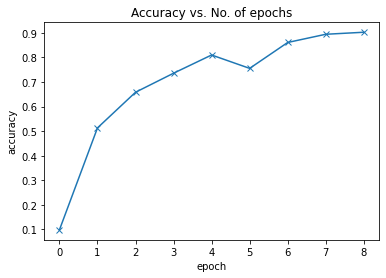

In [25]:
plot_accuracies(history)

추세를 연구하기 위해 훈련 및 검증 손실을 플롯할 수도 있습니다.

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

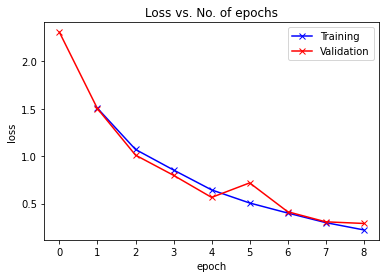

In [27]:
plot_losses(history)

마지막으로 시간이 지남에 따라 학습률이 모든 이포크에 걸쳐 배치별로 어떻게 변했는지 시각화해 보겠습니다.

In [28]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

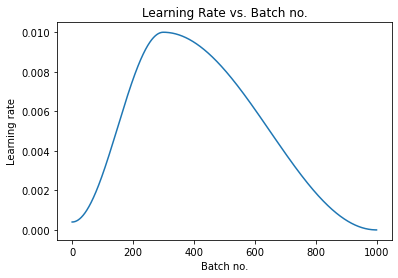

In [29]:
plot_lrs(history)

예상대로 학습률은 낮은 값에서 시작하여 30%의 반복 동안 점차 증가하여 최대값 '0.01'까지 도달한 다음 점차적으로 매우 작은 값으로 감소합니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Testing with individual images

지금까지 모델의 전반적인 정확도를 추적했지만 일부 샘플 이미지에서 모델의 결과를 살펴보는 것도 좋은 생각입니다. 미리 정의된 10000개 이미지의 테스트 데이터 세트에서 일부 이미지로 모델을 테스트해 보겠습니다.

In [30]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


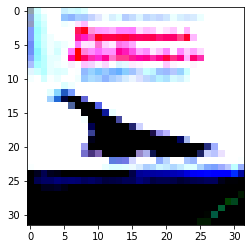

In [31]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: automobile


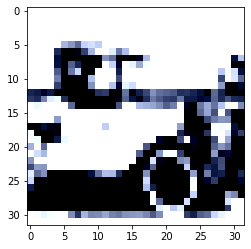

In [32]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: frog


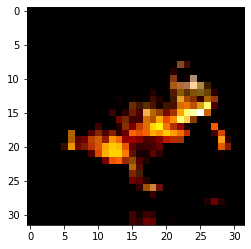

In [33]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

모델이 제대로 작동하지 않는 부분을 식별하면 더 많은 교육 데이터를 수집하고 모델의 복잡성을 늘리거나 줄이며 하이퍼파라미터를 변경하여 모델을 개선하는 데 도움이 될 수 있습니다.